# Visualization of cancer in SHARE's 8th wave

### Cancer

In the SHARE survey, cancer is defined as follow:

*"Has a doctor ever told you that you had/ Do you currently have cancer or malignant tumour, including leukaemia or lymphoma, but excluding minor skin cancers?"*.

### Visualization

The aim of this page is to visually explore the relationship between the cancer variable and other variables, in particular non-physical health variables such as demographics, feelings, mental health and habits.

### Get code

At [CIERI Analytics](https://www.cieri-analytics.com/), we focus on the reproducibility of our work. Want to explore this work further? Download the code by clicking <a href='cancer-visualization.ipynb'>here</a>.

## Packages

In [202]:
import os
import pandas as pd
import numpy as np
from scipy import stats

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot

# modelling
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

## Functions

I define here a few functions in order to make the code easier to read.

In [203]:
def kde_data(data):
    density = stats.gaussian_kde(data)
    xs = np.linspace(np.min(data), np.max(data), 200)
    ys = density(xs)*100
    return xs, ys

def encode_and_scale(X):
    # encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_categorical = pd.get_dummies(X[categorical_cols],
                                    columns = categorical_cols,
                                    drop_first = True)

    # scale numerical columns
    numeric_cols = X.select_dtypes(include=['float']).columns
    X_numerical = X[numeric_cols]
    X_numerical = (X_numerical-X_numerical.mean()) / X_numerical.std()

    # merge dfs
    X = pd.concat([X_categorical, X_numerical], axis=1)
    X = X.astype(float)
    return X

def compare_models(metric, metric_name, labels):
    
    #sort by metric
    metric, labels = zip(*sorted(zip(metric, labels)))
    
    #plot
    plt.figure(figsize=(10,5))
    plt.bar(labels, metric)
    plt.ylabel(metric_name)
    plt.xticks(rotation=30)
    plt.show()

def split_fit_predict(X, y, model=LogisticRegression(max_iter=1000), threshold=0.5, random_state=0, verbose=False):
    
    if verbose:
        print("Model:", type(model).__name__)
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    # train model
    model.fit(X_train, y_train)
    
    # prediction
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    preds = (preds > threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    roc = roc_auc_score(y_test, preds)
    rec = recall_score(y_test, preds)
    pre = precision_score(y_test, preds)

    if verbose:
        print(f"Accuracy: {(acc*100):.2f}%")
        print(f"AUC: {(roc):.4f}")
        print(f"Recall: {(rec):.4f}")
        print(f"Precision: {(pre):.4f}")
        print()
    
    # output
    return acc, roc, rec, pre

## Data cleaning

This cell opens and cleans the dataset.

In [204]:

br = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_br.dta')
dn = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_dn.dta')
ph = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_ph.dta')
mh = pd.read_stata('../../../SHARE/data/sharew8_rel8-0-0_ALL_datasets_stata/sharew8_rel8-0-0_mh.dta')

# drop variables
for df in [br, dn, ph, mh]:
    cols_to_drop = ['hhid8', 'mergeidp8', 'coupleid8']
    if df is not mh:
        cols_to_drop = ['hhid8', 'mergeidp8', 'coupleid8', 'country', 'language']
    df.drop(cols_to_drop, axis=1, inplace=True)

merged_dataframe = pd.merge(br, dn, on = 'mergeid')
merged_dataframe = pd.merge(merged_dataframe, ph, on = 'mergeid')
merged_dataframe = pd.merge(merged_dataframe, mh, on = 'mergeid')

#print([col for col in merged_dataframe.columns if col.startswith('ph')])
df = merged_dataframe[['dn014_', 'dn042_', 'dn003_', 'language',
                       'br001_', 'br015_', 'br016_', 'br039_',
                       'ph003_', 'ph084_', 'ph006d10', 'ph012_',
                       'ph013_', 'ph041_', 'ph745_', 'country',
                       'mh002_', 'mh003_', 'mh004_', 'mh005_',
                       'mh007_', 'mh008_', 'mh010_', 'mh011_',
                       'mh013_', 'mh015_', 'mh016_', 'mh017_'
                    ]]


df.rename(columns={
    'dn014_': 'MaritalStatus',
    'dn042_': 'Gender',
    'dn003_': 'YearOfBirth',
    'br001_': 'Smoking',
    'br015_': 'SportFrequencyVigorous',
    'br016_': 'SportFrequencyModerate',
    'br039_': 'Alcool',
    'ph003_': 'HealthSelfPerception',
    'ph084_': 'Pain',
    'ph006d10': 'Cancer',
    'ph012_': 'Weight',
    'ph013_': 'Height',
    'ph041_': 'Glasses',
    'ph745_': 'HearingAid',
    'mh002_': 'Depression',
    'mh003_': 'Hopelessness',
    'mh004_': 'WishDeath',
    'mh005_': 'Guilt',
    'mh007_': 'SleepTrouble',
    'mh008_': 'Interest',
    'mh010_': 'Irritable',
    'mh011_': 'Appetite',
    'mh013_': 'Fatigue',
    'mh015_': 'ConcentrationReading',
    'mh016_': 'Enjoyment',
    'mh017_': 'Tears',
    },
    inplace=True)

values_to_replace = ["Don't know", "Refusal",
                     "Implausible value/suspected wrong", 
                     "Not codable", "Not answered",
                     "Not yet coded", "Not applicable"]
df.replace(values_to_replace, float('NaN'), inplace=True)

column_types = {
    'YearOfBirth': 'float',
    'MaritalStatus': 'category',
    'Gender': 'category',
    'Smoking': 'category',
    'SportFrequencyVigorous': 'category',
    'SportFrequencyModerate': 'category',
    'HealthSelfPerception': 'category',
    'Pain': 'category',
    'Cancer': 'category',
    'Weight': 'float',
    'Height': 'float',
    'Glasses': 'category',
    'HearingAid': 'category',
    'Depression': 'category',
    'Hopelessness': 'category',
    'WishDeath': 'category',
    'Guilt': 'category',
    'SleepTrouble': 'category',
    'Interest': 'category',
    'Irritable': 'category',
    'Appetite': 'category',
    'Fatigue': 'category',
    'ConcentrationReading': 'category',
    'Enjoyment': 'category',
    'Tears': 'category',
}
df = df.astype(column_types)

df['Age'] = 2021 - df['YearOfBirth']
df.drop(['YearOfBirth'], axis=1, inplace=True)
categorical_columns = df.select_dtypes(include=['category']).columns
for col in categorical_columns:
    df[col].cat.add_categories('Unknown').fillna('Unknown', inplace=True)

# last modifications
df = df.loc[df.Cancer != 'Unknown',]
df = df.loc[df.Age >= 50,]
df.to_csv('../../data/br_dn_ph_wave8.csv', index=False)

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_8229/2126246111.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/m2/jfzxyg4s0xz3jyw5f94r7tcm0000gn/T/ipykernel_8229/2126246111.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Cancer

In [205]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')
print(df.Cancer.value_counts()/len(df)*100)

# split in cancer and no cancer
df_c = df.loc[df['Cancer']=='Selected', ]
df_nc = df.loc[df['Cancer']=='Not selected', ]

Cancer
Not selected    94.374812
Selected         5.324720
Name: count, dtype: float64


## Age distribution for people with and without cancer

In [206]:
# compute density
xs_c, ys_c = kde_data(df_c['Age'])
xs_nc, ys_nc = kde_data(df_nc['Age'])

# Create the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=xs_c, y=ys_c, mode='lines', name='Selected', fill='tozeroy', 
                         line_color='red', opacity=0.5))
fig.add_trace(go.Scatter(x=xs_nc, y=ys_nc, mode='lines', name='Not Selected', fill='tozeroy', 
                         line_color='blue', opacity=0.5))

# Update layout
fig.update_layout(
    title='Age Distribution split by Cancer',
    xaxis_title='Age',
    yaxis_title='Density',
    yaxis=dict(showticklabels=False),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=20, r=20, t=20, b=20),
    width=1000,
    height=600,
    plot_bgcolor='white'
)

# Update axes to remove certain spines
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showgrid=False, zeroline=False, showline=False)
#fig.show()

# save figure
plot(fig, filename="../../img/plotly/age_distribution_cancer.html")

# print t test for age
stats.ttest_ind(df_c['Age'], df_nc['Age'])

TtestResult(statistic=12.386002514662943, pvalue=3.536744554793488e-35, df=46452.0)

<iframe src="../../img/plotly/age_distribution_cancer.html" width="800" height="600"></iframe>

## Correlation between features

In [207]:
encode_and_scale(df).corr()

,MaritalStatus_Married and living together with spouse,"MaritalStatus_Married, living separated from spouse",MaritalStatus_Never married,MaritalStatus_Registered partnership,MaritalStatus_Widowed,Gender_Male,language_Bulgarian,language_Catalan (eg),language_Catalan (es),language_Croatian,...,Irritable_Yes,Appetite_No diminution in desire for food,Appetite_Non-specific or uncodeable response,Fatigue_Yes,ConcentrationReading_No such difficulty mentioned,Enjoyment_Mentions any enjoyment from activity,Tears_Yes,Weight,Height,Age
MaritalStatus_Married and living together with spouse,1.000000,-0.022008,-0.044327,-0.024882,-0.117255,0.067023,0.176373,-0.044763,-0.009580,-0.020417,...,0.049240,0.021208,0.023872,-0.011709,0.026363,-0.024088,-0.016210,0.069459,0.140946,-0.181104
"MaritalStatus_Married, living separated from spouse",-0.022008,1.000000,-0.005157,-0.002895,-0.013642,0.010600,0.014478,-0.005755,-0.001367,-0.008181,...,0.005576,-0.005133,0.003246,0.001408,-0.003903,-0.009617,0.002290,0.006001,0.003073,-0.028171
MaritalStatus_Never married,-0.044327,-0.005157,1.000000,-0.005831,-0.027476,0.016364,0.038148,-0.011591,0.005125,-0.008376,...,0.010788,0.009845,0.004764,0.008158,-0.012218,-0.013716,-0.011875,0.005000,0.012306,-0.060489
MaritalStatus_Registered partnership,-0.024882,-0.002895,-0.005831,1.000000,-0.015423,0.012388,0.011069,-0.006507,-0.001546,0.007471,...,0.001999,0.004710,0.001243,-0.010990,0.005007,0.002025,0.003195,0.004671,0.035837,-0.034840
MaritalStatus_Widowed,-0.117255,-0.013642,-0.027476,-0.015423,1.000000,-0.112659,0.126254,-0.010126,-0.004123,-0.014864,...,-0.016764,-0.070819,0.013595,0.067775,-0.063620,-0.070616,0.141714,-0.049737,-0.207323,0.153785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Enjoyment_Mentions any enjoyment from activity,-0.024088,-0.009617,-0.013716,0.002025,-0.070616,-0.007659,-0.026767,0.004613,0.000785,0.017986,...,-0.044020,0.257255,-0.049585,-0.099437,0.316991,1.000000,-0.060166,0.031739,0.037328,-0.144009
Tears_Yes,-0.016210,0.002290,-0.011875,0.003195,0.141714,-0.246360,0.003914,-0.005705,0.003909,0.000794,...,0.195373,-0.118145,0.031554,0.215020,-0.104114,-0.060166,1.000000,-0.069346,-0.204591,0.008586
Weight,0.069459,0.006001,0.005000,0.004671,-0.049737,0.390997,-0.002101,-0.030266,-0.017323,0.033788,...,0.025799,0.084067,0.001683,0.005307,0.039253,0.031739,-0.069346,1.000000,0.461565,-0.156450
Height,0.140946,0.003073,0.012306,0.035837,-0.207323,0.611827,-0.017772,0.025982,-0.020219,0.037737,...,0.001084,0.039042,0.017470,-0.065930,0.058299,0.037328,-0.204591,0.461565,1.000000,-0.144661


<br>

## Modelling cancer with machine learning

In [208]:
df = pd.read_csv('../../data/br_dn_ph_wave8.csv')
df['Cancer'] = df['Cancer'].replace({'Selected': 1, 'Not selected': 0})
df.dropna(subset=['Cancer'], inplace=True)
df.dropna(subset=['Weight'], inplace=True)
target = 'Cancer'
y = df[target]
df.drop([target, 'Height'], axis=1, inplace=True)
X = encode_and_scale(df)


In [209]:
X.isna().sum().sum()

0

Model: LogisticRegression
Accuracy: 66.87%
AUC: 0.6707
Recall: 0.6729
Precision: 0.0996

Model: RandomForestClassifier
Accuracy: 64.88%
AUC: 0.6634
Recall: 0.6797
Precision: 0.0950

Model: AdaBoostClassifier
Accuracy: 67.17%
AUC: 0.6739
Recall: 0.6763
Precision: 0.1008

Model: GradientBoostingClassifier
Accuracy: 66.54%
AUC: 0.6810
Recall: 0.6985
Precision: 0.1016

Model: DecisionTreeClassifier
Accuracy: 56.60%
AUC: 0.5795
Recall: 0.5945
Precision: 0.0692

Model: SVC
Accuracy: 67.22%
AUC: 0.6798
Recall: 0.6882
Precision: 0.1024

Model: KNeighborsClassifier
Accuracy: 60.94%
AUC: 0.5943
Recall: 0.5775
Precision: 0.0749

Model: MLPClassifier
Accuracy: 59.06%
AUC: 0.6078
Recall: 0.6269
Precision: 0.0767

Model: BaggingClassifier
Accuracy: 67.07%
AUC: 0.6443
Recall: 0.6150
Precision: 0.0931



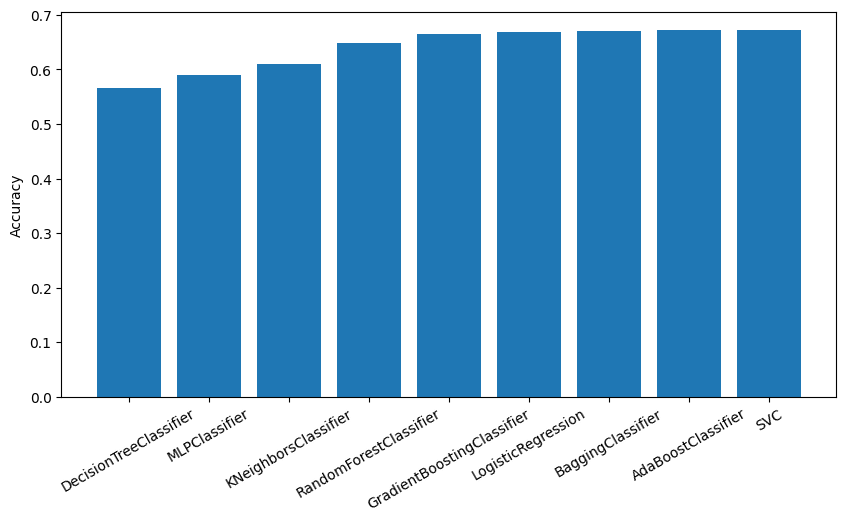

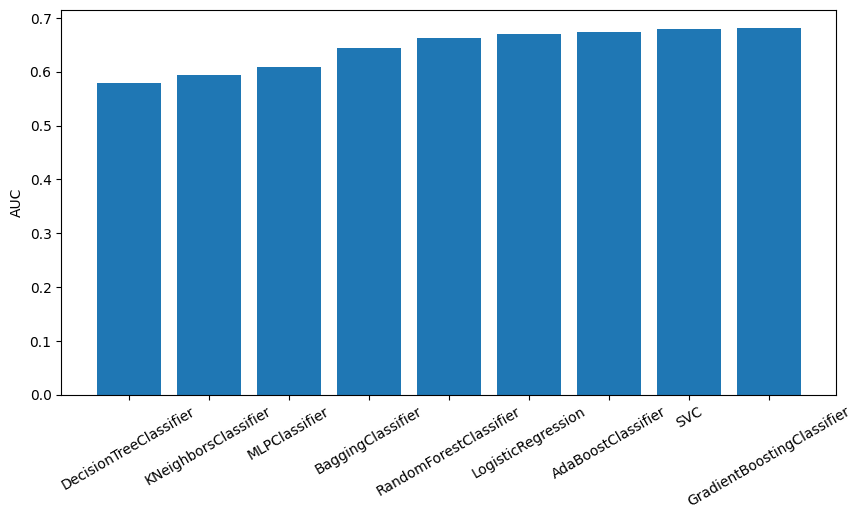

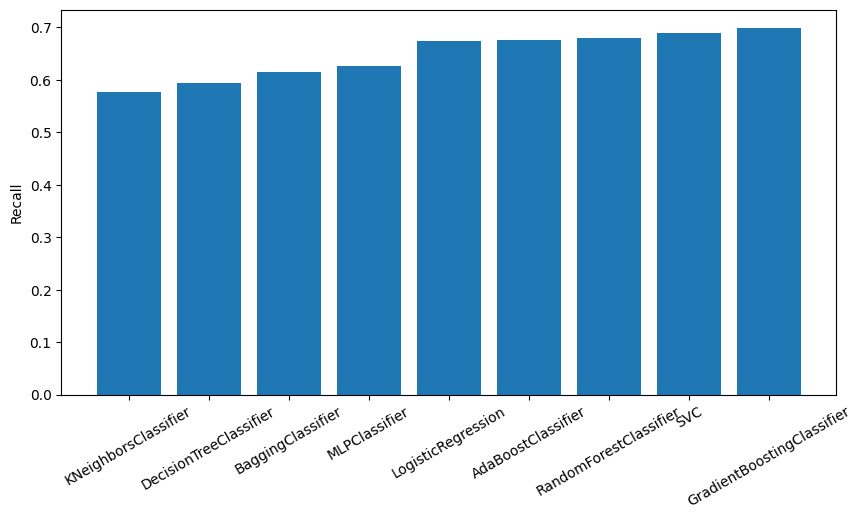

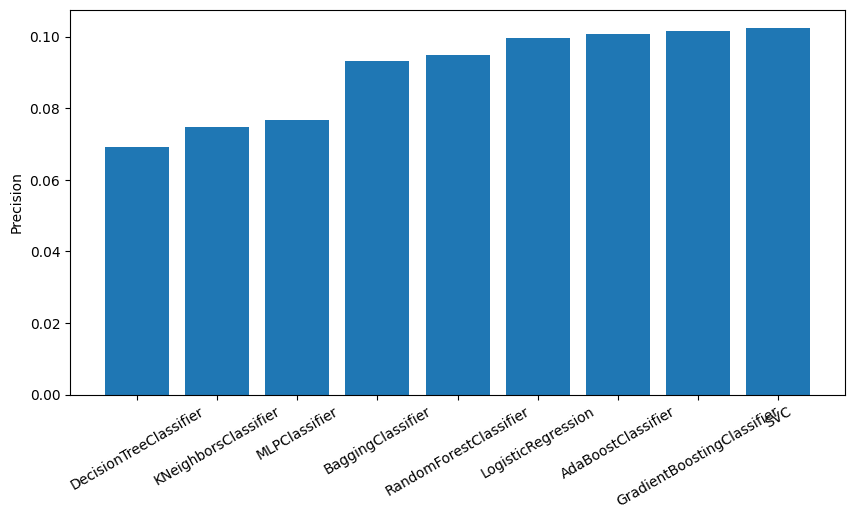

In [212]:
# fit model
accs = []
rocs = []
recs = []
pres = []
labels = []
models = [LogisticRegression(max_iter=1000),
            RandomForestClassifier(),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            DecisionTreeClassifier(),
            SVC(probability=True),
            KNeighborsClassifier(),
            MLPClassifier(max_iter=1000),
            BaggingClassifier()]
for model in models:
    labels.append(type(model).__name__)
    acc, roc, rec, pre = split_fit_predict(X, y, model=model, random_state=0, verbose=True)
    accs.append(acc)
    rocs.append(roc)
    recs.append(rec)
    pres.append(pre)

# plot results
compare_models(accs, 'Accuracy', labels)
compare_models(rocs, 'AUC', labels)
compare_models(recs, 'Recall', labels)
compare_models(pres, 'Precision', labels)